In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc # 폰트 설정과 한글깨짐 방기
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import seaborn as sns
import os
from tqdm.autonotebook import tqdm # loop의 진행상황을 시각적으로 표현하기 위한 라이브러리

from itertools import product # 효율적으로 loop를 생성하기 위한 라이브러리

from tslearn.clustering import TimeSeriesKMeans # TimeSeriesKMeans 클러스터링 import

from sklearn.preprocessing import StandardScaler # 데이터 정규화에 사용할 StandardScaler import
from sklearn.metrics import silhouette_score # 성능 지표를 계산하기 위해 silhouette_score import
from sklearn.cluster import DBSCAN # DBSCAN 클러스터링 import

sns.set_style("darkgrid")

SEED=23

C:\Users\User\anaconda3\envs\MRI_py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\envs\MRI_py38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\User\anaconda3\envs\MRI_py38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %
C:\Users\User\AppData\Local\Temp/ipykernel_26480/2392732854.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm # loop의 진행상황을 시각적으로 표현하기 위한 라이브러리


In [2]:
# 경고 메세지 off
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# Data load
address = './../data_processing/Dataset/'
data = pd.read_csv(os.path.join(address,'df_pm10_7day_result_1110.csv'), header = 0, encoding='cp949')
data.head()

in_serial         in_id             time_day  in_pm10_day
0       요양원  ICL1L2000011  2020-07-22 00:00:00         21.5
1       요양원  ICL1L2000011  2020-07-22 00:10:00         22.3
2       요양원  ICL1L2000011  2020-07-22 00:20:00         21.8
3       요양원  ICL1L2000011  2020-07-22 00:30:00         21.5
4       요양원  ICL1L2000011  2020-07-22 00:40:00         21.5

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153211 entries, 0 to 153210
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   in_serial    153211 non-null  object 
 1   in_id        153211 non-null  object 
 2   time_day     153211 non-null  object 
 3   in_pm10_day  152785 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.7+ MB


In [5]:
# in_serial = 장소 정보와 in_id =data sample id만 data_cd로 생성
data_cd = data[['in_serial','in_id']]
data_cd = data_cd.drop_duplicates()
data_cd = data_cd.set_index(keys='in_id')

In [6]:
data_cd

in_serial
in_id                 
ICL1L2000011       요양원
ICL1L2000017       요양원
ICL1L2000064      체육시설
ICL1L2000065      체육시설
ICL1L2000234       경로당
...                ...
IS70W2000853       요양원
IS70W2000854       요양원
IS70W2000855       요양원
IS70W2000856       요양원
IS70W2000858       요양원

[152 rows x 1 columns]

In [7]:
print(data['in_id'].unique(), len(data['in_id'].unique()))

['ICL1L2000011' 'ICL1L2000017' 'ICL1L2000064' 'ICL1L2000065'
 'ICL1L2000234' 'ICL1L2000235' 'ICL1L2000236' 'ICL1L2000237'
 'ICL1L2000238' 'ICL1L2000239' 'ICL1L2000240' 'ICL1L2000241'
 'ICL1L2000242' 'ICL1L2000244' 'ICL1L2000245' 'ICL1L2000246'
 'ICL1L2000247' 'ICL1L2000248' 'ICL1L2000249' 'ICL1L2000252'
 'ICL1L2000253' 'ICL1L2000254' 'ICL1L2000255' 'ICL1L2000257'
 'ICL1L2000258' 'ICL1L2000259' 'ICL1L2000260' 'ICL1L2000262'
 'ICL1L2000263' 'ICL1L2000265' 'ICL1L2000266' 'ICL1L2000267'
 'ICL1L2000268' 'ICL1L2000269' 'ICL1L2000271' 'ICL1L2000272'
 'ICL1L2000274' 'ICL1L2000275' 'ICL1L2000276' 'ICL1L2000277'
 'ICL1L2000278' 'ICL1L2000279' 'ICL1L2000280' 'ICL1L2000281'
 'ICL1L2000283' 'ICW0W2000011' 'ICW0W2000012' 'ICW0W2000013'
 'ICW0W2000014' 'ICW0W2000015' 'ICW0W2000016' 'ICW0W2000018'
 'ICW0W2000019' 'ICW0W2000020' 'ICW0W2000022' 'ICW0W2000023'
 'ICW0W2000024' 'ICW0W2000025' 'ICW0W2000031' 'ICW0W2000032'
 'ICW0W2000033' 'ICW0W2000034' 'ICW0W2000087' 'ICW0W2000088'
 'ICW0W2000089' 'ICW0W20

In [8]:
# 클러스터링을 진행하기 위해 data table 형태 변환
df_pivot = pd.DataFrame()
for in_data_cd in data['in_id'].unique():
    
    sample = data[data['in_id'] == in_data_cd]
    # print(len(sample))
    time_index = []
    for i in range(0,len(sample)):
        time_index.append(i)
    sample['time_index'] = time_index
    #print(time_index)
    df_pivot = pd.concat([df_pivot,sample], ignore_index=True)

In [9]:
df_pivot= df_pivot.pivot_table(index="time_index",
                       columns="in_id",
                       values="in_pm10_day")

In [10]:
df_pivot

in_id       ICL1L2000011  ICL1L2000017  ICL1L2000064  ICL1L2000065  \
time_index                                                           
0                   21.5          11.4          15.3          16.2   
1                   22.3          11.3          15.2          16.2   
2                   21.8          11.3          16.1          16.6   
3                   21.5          11.5          14.5          16.7   
4                   21.5          11.1          16.9          16.9   
...                  ...           ...           ...           ...   
1003                 3.8           3.3          19.3          13.8   
1004                 4.0           3.6          19.8          14.0   
1005                 3.9           4.1          21.8          14.7   
1006                 4.1           5.5          20.7          14.2   
1007                 4.3           7.2          21.7          14.8   

in_id       ICL1L2000234  ICL1L2000235  ICL1L2000236  ICL1L2000237  \
time_index                                                           
0                   43.3          29.1          18.6          23.5   
1                   43.5          28.8          18.5          23.3   
2                   42.5          27.8          18.6          23.7   
3                   41.9          27.0          19.0          23.6   
4                   42.2          27.5          18.5          23.8   
...                  ...           ...           ...           ...   
1003                37.1          10.8          38.4           0.0   
1004                37.5          10.8          39.0           0.2   
1005                37.1          10.0          39.7           0.2   
1006                37.5           9.5          40.3           0.3   
1007                37.0           9.8          40.0           0.4   

in_id       ICL1L2000238  ICL1L2000239  ...  ICW0W2100277  ICW0W2100278  \
time_index                              ...                               
0                   61.0          52.7  ...           3.0           3.2   
1                   60.9          52.5  ...           3.2           3.8   
2                   60.6          52.5  ...           3.4           3.3   
3                   60.4          52.6  ...           3.4           3.7   
4                   60.2          52.0  ...           3.6           3.8   
...                  ...           ...  ...           ...           ...   
1003                13.6          42.3  ...          11.2          10.9   
1004                14.6          42.5  ...          11.0          11.0   
1005                14.9          43.2  ...          11.1          11.1   
1006                17.2          45.6  ...          11.1          10.9   
1007                18.6          46.5  ...          11.0          10.9   

in_id       IS70W2000822  IS70W2000851  IS70W2000852  IS70W2000853  \
time_index                                                           
0                  98.97           9.9           5.0           5.9   
1                  98.94           8.5           5.0           6.2   
2                  98.76           8.2           4.4           6.0   
3                  98.42           8.2           4.5           5.6   
4                  98.59           6.9           5.4           5.6   
...                  ...           ...           ...           ...   
1003               98.03           3.0           5.0           5.9   
1004               98.00           2.6           5.0           6.4   
1005               98.18           2.2           5.6           7.2   
1006               98.09           2.3           5.7           6.1   
1007               98.18           2.4           5.7           6.5   

in_id       IS70W2000854  IS70W2000855  IS70W2000856  IS70W2000858  
time_index                                                          
0                    0.7           8.7          14.1          12.6  
1                    1.0           9.5          14.6          12.2  
2              

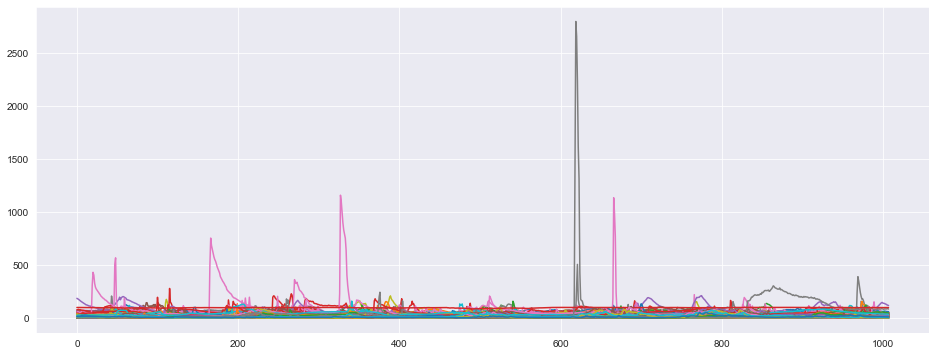

In [11]:
## df_pivot 시각화
fig, ax = plt.subplots(figsize=(16, 6))
for col in df_pivot.columns[1:]:
    df_pivot[col] = df_pivot[col].astype('float64')
    df_pivot.plot(y=col, use_index=False, ax=ax,legend = False)
    #plt.savefig(address + '/images/all_day30.png')
plt.show()

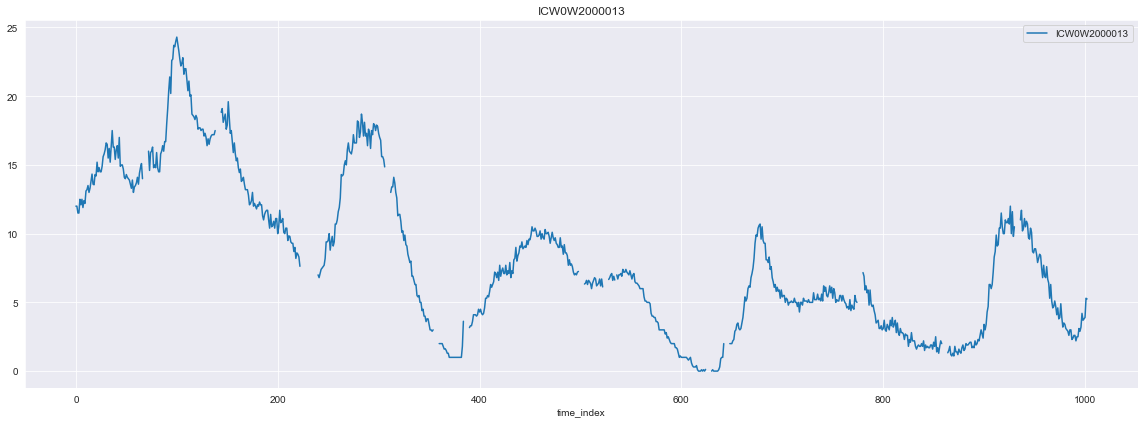

In [12]:
# ICW0W2000013 하나만 시각화한 결과
for col in df_pivot[['ICW0W2000013']].columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    df_pivot.plot(y=col, use_index=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

In [13]:
# 선형보간법 사용

df_pivot_int = df_pivot.interpolate(method='linear')

In [14]:
df_pivot_int.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
             998,  999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007],
           dtype='int64', name='time_index', length=1008)

In [15]:
# 데이터 가장 앞 부분에 존재하는 결측값은 이전 값으로 대체함
df_pivot_int_test = df_pivot_int.reindex(df_pivot_int.index, method="ffill")

In [16]:
# 데이터 가장 끝부분에 존재하는 결측값은 이전 값으로 대체함
df_pivot_int_test = df_pivot_int.reindex(df_pivot_int.index, method="bfill")

In [17]:
x = df_pivot_int_test[['ICW0W2000013', 'ICW0W2000016','ICW0W2000015']]
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ICW0W2000013  1008 non-null   float64
 1   ICW0W2000016  1008 non-null   float64
 2   ICW0W2000015  1008 non-null   float64
dtypes: float64(3)
memory usage: 31.5 KB


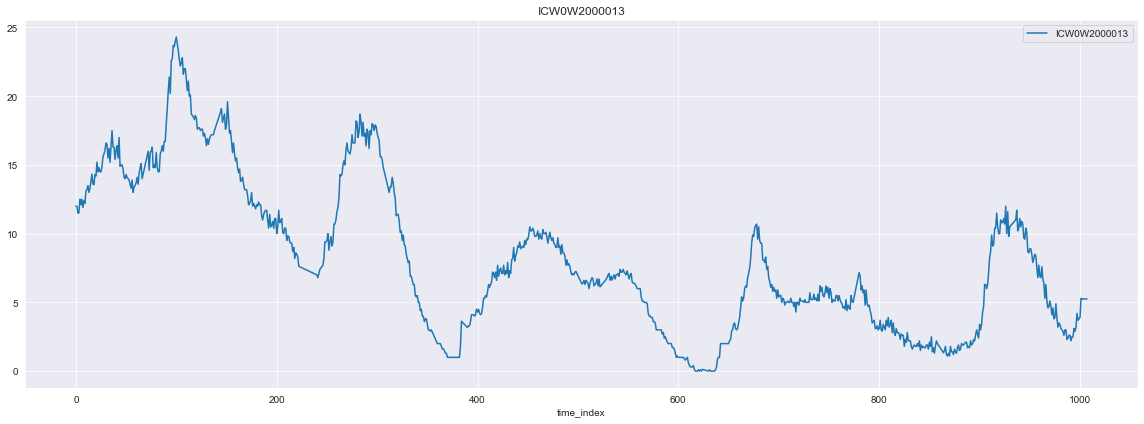

In [18]:
# 선형 보간 결과 시각화
for col in df_pivot_int_test[['ICW0W2000013']].columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    df_pivot_int_test.plot(y=col, use_index=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

In [19]:
series_df = df_pivot_int_test.T
series_df = series_df.dropna(axis='columns')
series_df.head()

time_index    0     1     2     3     4     5     6          7     8     9     \
in_id                                                                           
ICL1L2000011  21.5  22.3  21.8  21.5  21.5  21.1  20.3  21.777778  22.4  21.9   
ICL1L2000017  11.4  11.3  11.3  11.5  11.1  11.8  12.0  12.200000  12.4  13.1   
ICL1L2000064  15.3  15.2  16.1  14.5  16.9  15.3  15.5  15.500000  15.9  16.8   
ICL1L2000065  16.2  16.2  16.6  16.7  16.9  16.6  16.8  17.100000  17.3  17.3   
ICL1L2000234  43.3  43.5  42.5  41.9  42.2  41.8  42.8  42.800000  42.9  43.0   

time_index    ...  998   999   1000  1001  1002  1003  1004  1005  1006  1007  
in_id         ...                                                              
ICL1L2000011  ...   4.5   4.2   4.3   3.6   4.0   3.8   4.0   3.9   4.1   4.3  
ICL1L2000017  ...   3.4   3.8   3.8   4.4   3.9   3.3   3.6   4.1   5.5   7.2  
ICL1L2000064  ...  18.1  18.4  17.9  19.8  19.1  19.3  19.8  21.8  20.7  21.7  
ICL1L2000065  ...  12.6  12.4  12.1  12.5  13.3  13.8  14.0  14.7  14.2  14.8  
ICL1L2000234  ...  36.5  36.9  36.8  37.2  36.9  37.1  37.5  37.1  37.5  37.0  

[5 rows x 1008 columns]

In [20]:
# Scaling
scaler = StandardScaler() # StandardScaler 정규화 객체 생성

scaled_ts = scaler.fit_transform(series_df.T).T # df_pivot에 대해 정규화를 진행함
scaled_ts_df = pd.DataFrame(scaled_ts)

In [21]:
scaled_ts_df.head()

0         1         2         3         4         5         6     \
0  1.281037  1.354580  1.308616  1.281037  1.281037  1.244266  1.170723   
1 -0.657221 -0.661821 -0.661821 -0.652621 -0.671021 -0.638821 -0.629621   
2 -0.646572 -0.654100 -0.586349 -0.706795 -0.526125 -0.646572 -0.631516   
3 -0.704346 -0.704346 -0.682050 -0.676477 -0.665329 -0.682050 -0.670903   
4  0.769132  0.783587  0.711316  0.667953  0.689634  0.660726  0.732997   

       7         8         9     ...      998       999       1000      1001  \
0  1.306573  1.363773  1.317809  ... -0.281754 -0.309333 -0.300140 -0.364490   
1 -0.620421 -0.611222 -0.579022  ... -1.025215 -1.006816 -1.006816 -0.979216   
2 -0.631516 -0.601405 -0.533653  ... -0.435790 -0.413207 -0.450846 -0.307816   
3 -0.654182 -0.643034 -0.643034  ... -0.905002 -0.916149 -0.932870 -0.910575   
4  0.732997  0.740224  0.747451  ...  0.277689  0.306597  0.299370  0.328279   

       1002      1003      1004      1005      1006      1007  
0 -0.327719 -0.346104 -0.327719 -0.336912 -0.318526 -0.300140  
1 -1.002216 -1.029815 -1.016016 -0.993016 -0.928617 -0.850418  
2 -0.360511 -0.345456 -0.307816 -0.157258 -0.240065 -0.164786  
3 -0.865985 -0.838116 -0.826969 -0.787952 -0.815821 -0.782378  
4  0.306597  0.321052  0.349960  0.321052  0.349960  0.313824  

[5 rows x 1008 columns]

In [22]:
namesofMySeries = []
for ind, i in enumerate(series_df.T):
    namesofMySeries.append(i)

In [23]:
def get_kmeans_results(data, max_clusters=10, metric='euclidean', seed=23):
    """
    KMeans 실행 과 결과 시각화

    data: pd.DataFrame or np.array
        Time Series Data
    max_clusters: int
        Number of different clusters for KMeans algorithm
    metric: str
        Distance metric between the observations
    seed: int
        random seed
    Returns: 
    -------
    None      
    """
    # Main metrics
    distortions = []
    silhouette = []
    clusters_range = range(1, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=-1, max_iter=10, random_state=seed)
        kmeans_model.fit(data)
        distortions.append(kmeans_model.inertia_)
        if K > 1:
            silhouette.append(silhouette_score(data, kmeans_model.labels_))
        
    # Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[1:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette')


In [29]:
 def plot_cluster_ts(current_cluster):
    """
    시계열 클러스터 결과 선 그래프로 시각화

    current_cluster: np.array
        Cluster with time series 
    Returns:
    -------
    None 
    """
    Cluster_idx=[]
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),4,
        figsize=(45, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for i in range(len(current_cluster)):
        ax[i].plot(current_cluster.iloc[i,:])
        plt.xticks(rotation=45)
        Cluster_idx.append(current_cluster.index[i])
        
    plt.tight_layout()
    plt.show()
    print(Cluster_idx);

  0%|          | 0/10 [00:00<?, ?it/s]

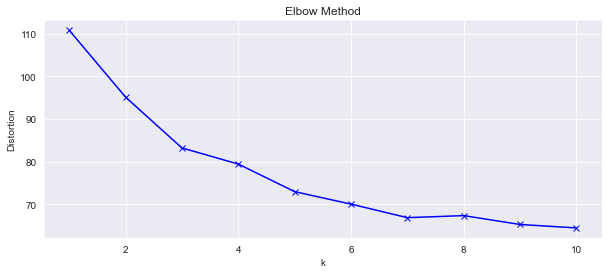

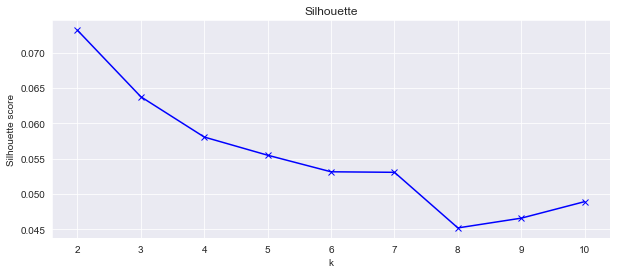

In [24]:
# DTW algorithm을 사용하여 TimeSeriesKMeans 진행
get_kmeans_results(data=scaled_ts_df, max_clusters=10, metric='dtw', seed=SEED)

In [31]:
# in_id의 군집결과 조회
cluster_model = TimeSeriesKMeans(n_clusters=3, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)
cluster_labels = cluster_model.fit_predict(scaled_ts_df)
fancy_names_for_labels = [f"Cluster {label}" for label in cluster_labels]
result = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

ts_clustered = [scaled_ts_df.iloc[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]

result

Cluster
Series                 
IS70W2000858  Cluster 0
ICL1L2000272  Cluster 0
ICL1L2000274  Cluster 0
ICL1L2000275  Cluster 0
ICL1L2000276  Cluster 0
...                 ...
ICW0W2000792  Cluster 2
ICW0W2000790  Cluster 2
ICW0W2000789  Cluster 2
ICW0W2000799  Cluster 2
ICW0W2000809  Cluster 2

[152 rows x 1 columns]

In [33]:
# 군집별 data sample 수 조회
merge_outer = pd.merge(result,data_cd, how='outer', left_index=True, right_index=True)
result_cnt = merge_outer.groupby('Cluster').count().reset_index()
result_cnt

Cluster  in_serial
0  Cluster 0         60
1  Cluster 1         40
2  Cluster 2         52

==========Cluster number: 0==========


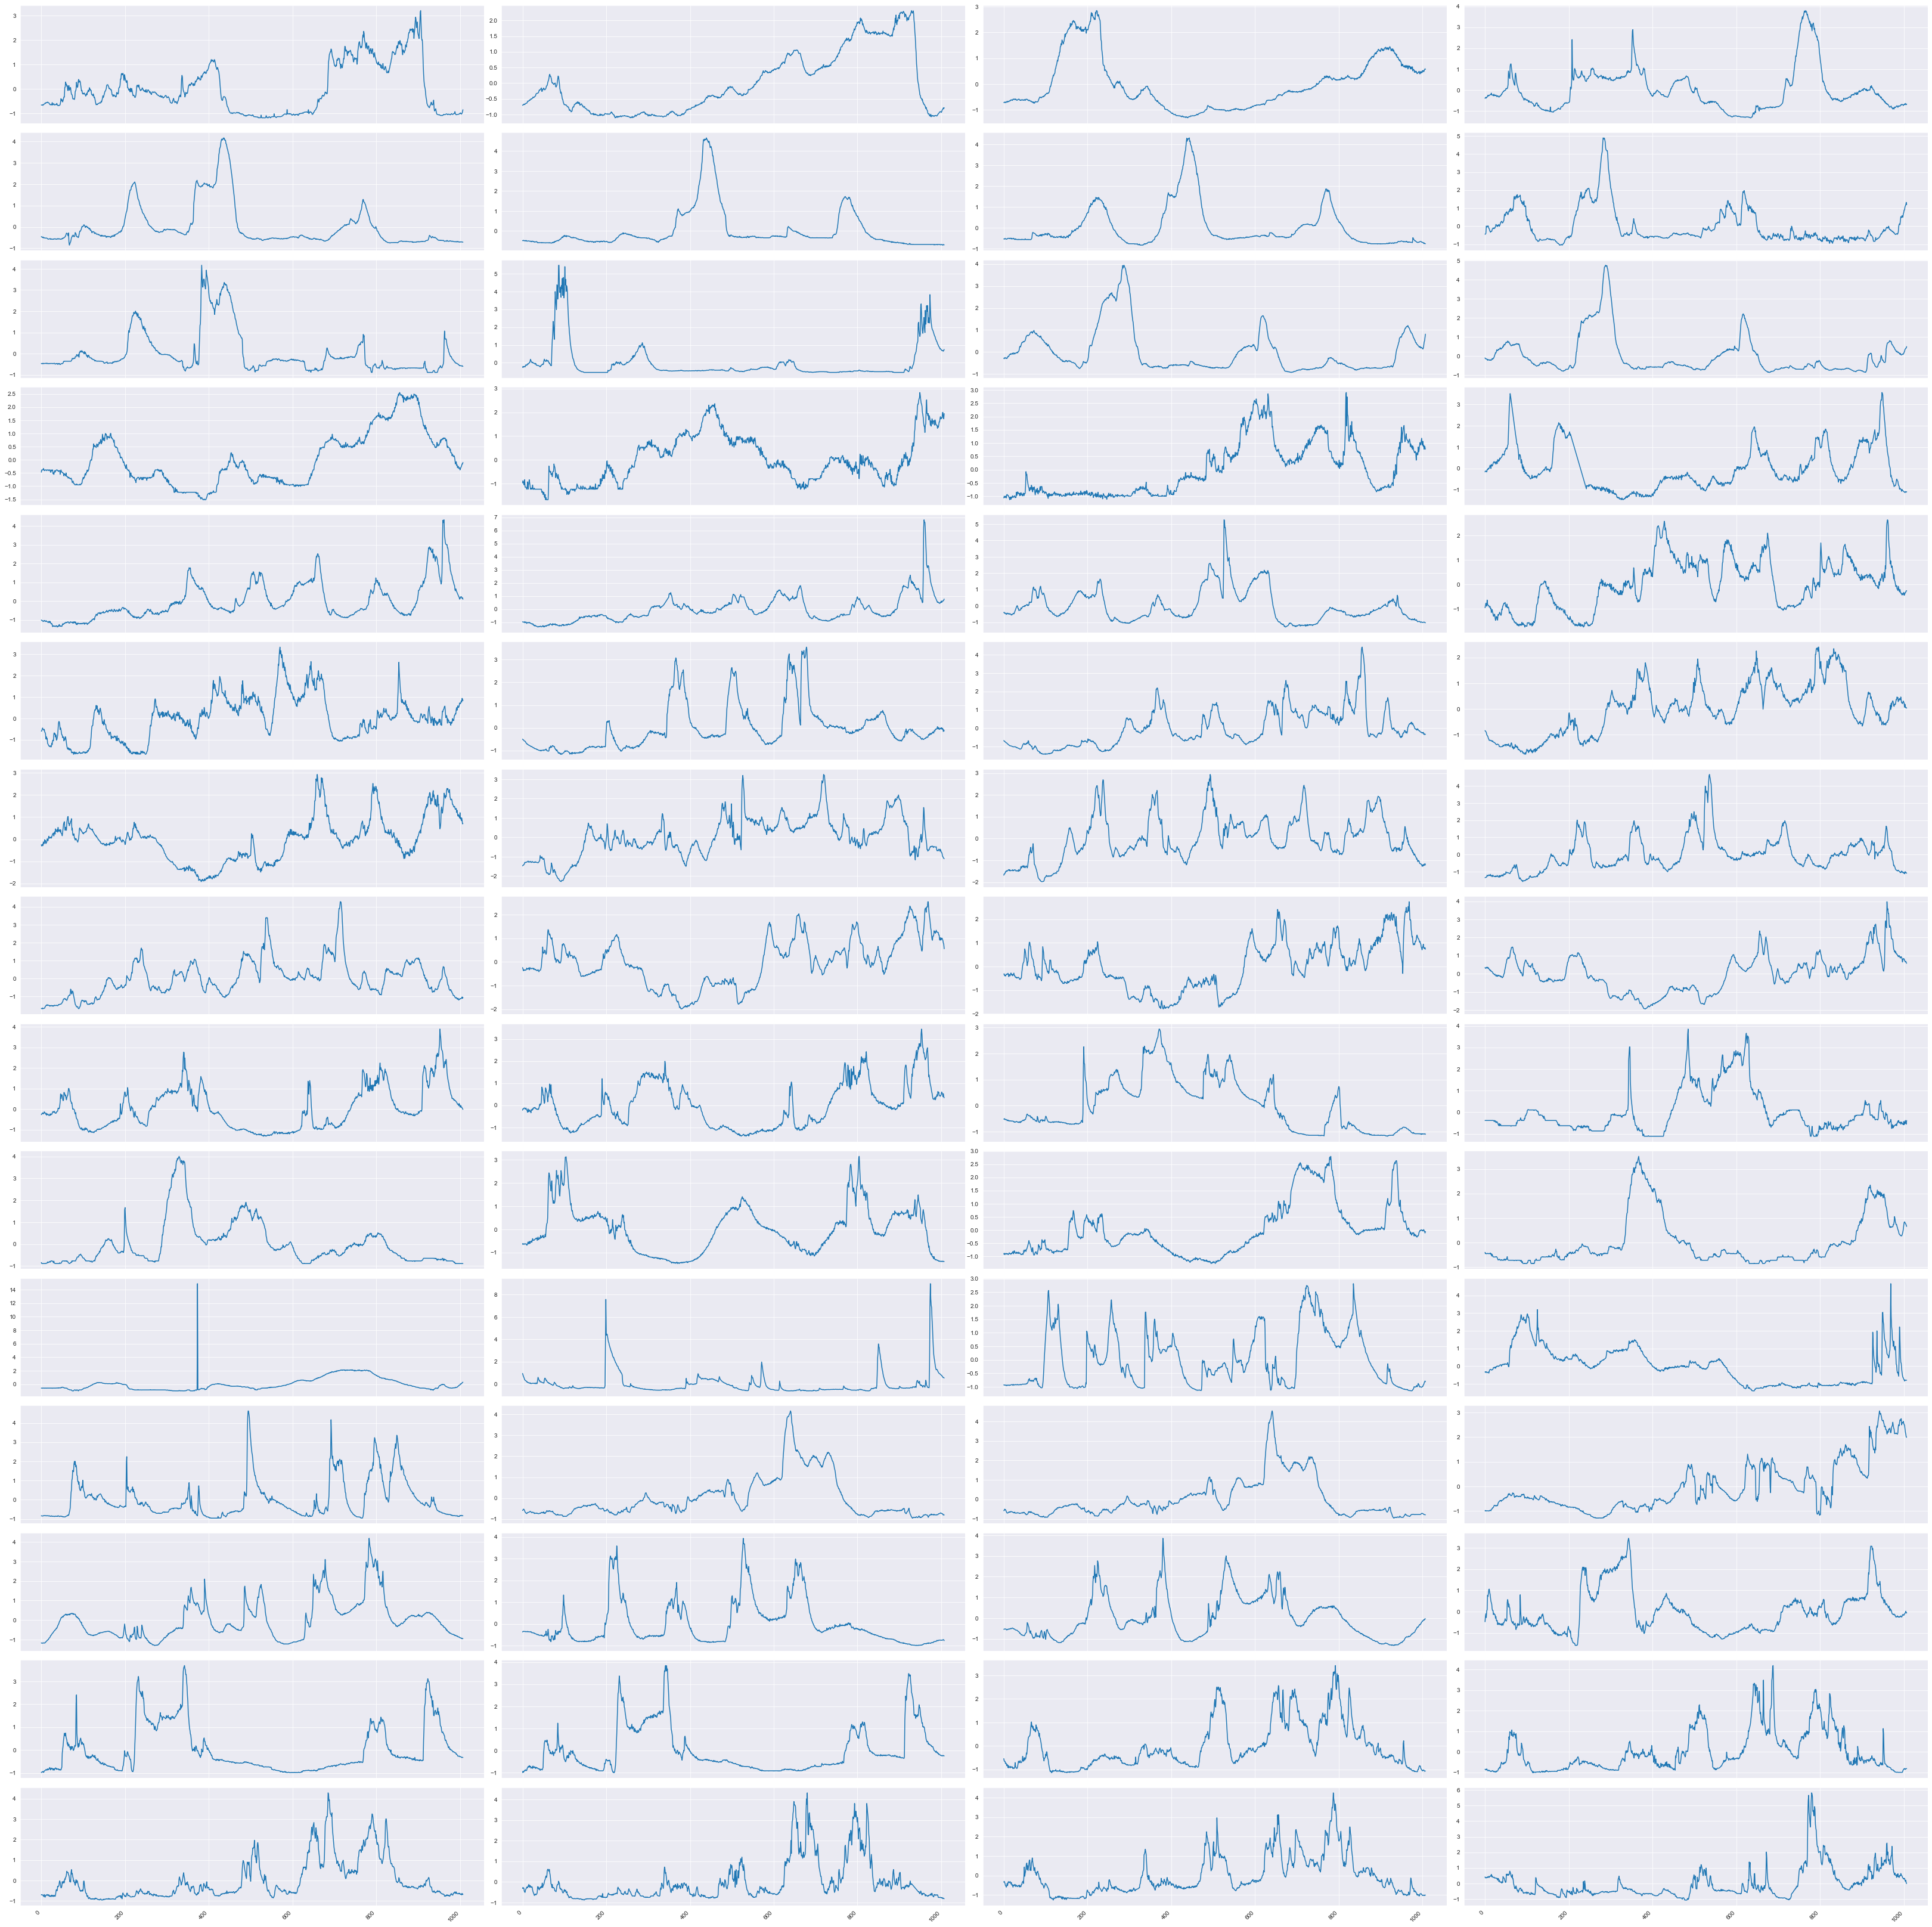

[1, 3, 6, 23, 29, 30, 32, 33, 35, 36, 37, 38, 39, 45, 46, 48, 49, 50, 53, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 80, 82, 83, 84, 92, 102, 116, 119, 125, 131, 132, 133, 135, 136, 137, 141, 142, 143, 145, 146, 147, 149, 150, 151]
==========Cluster number: 1==========


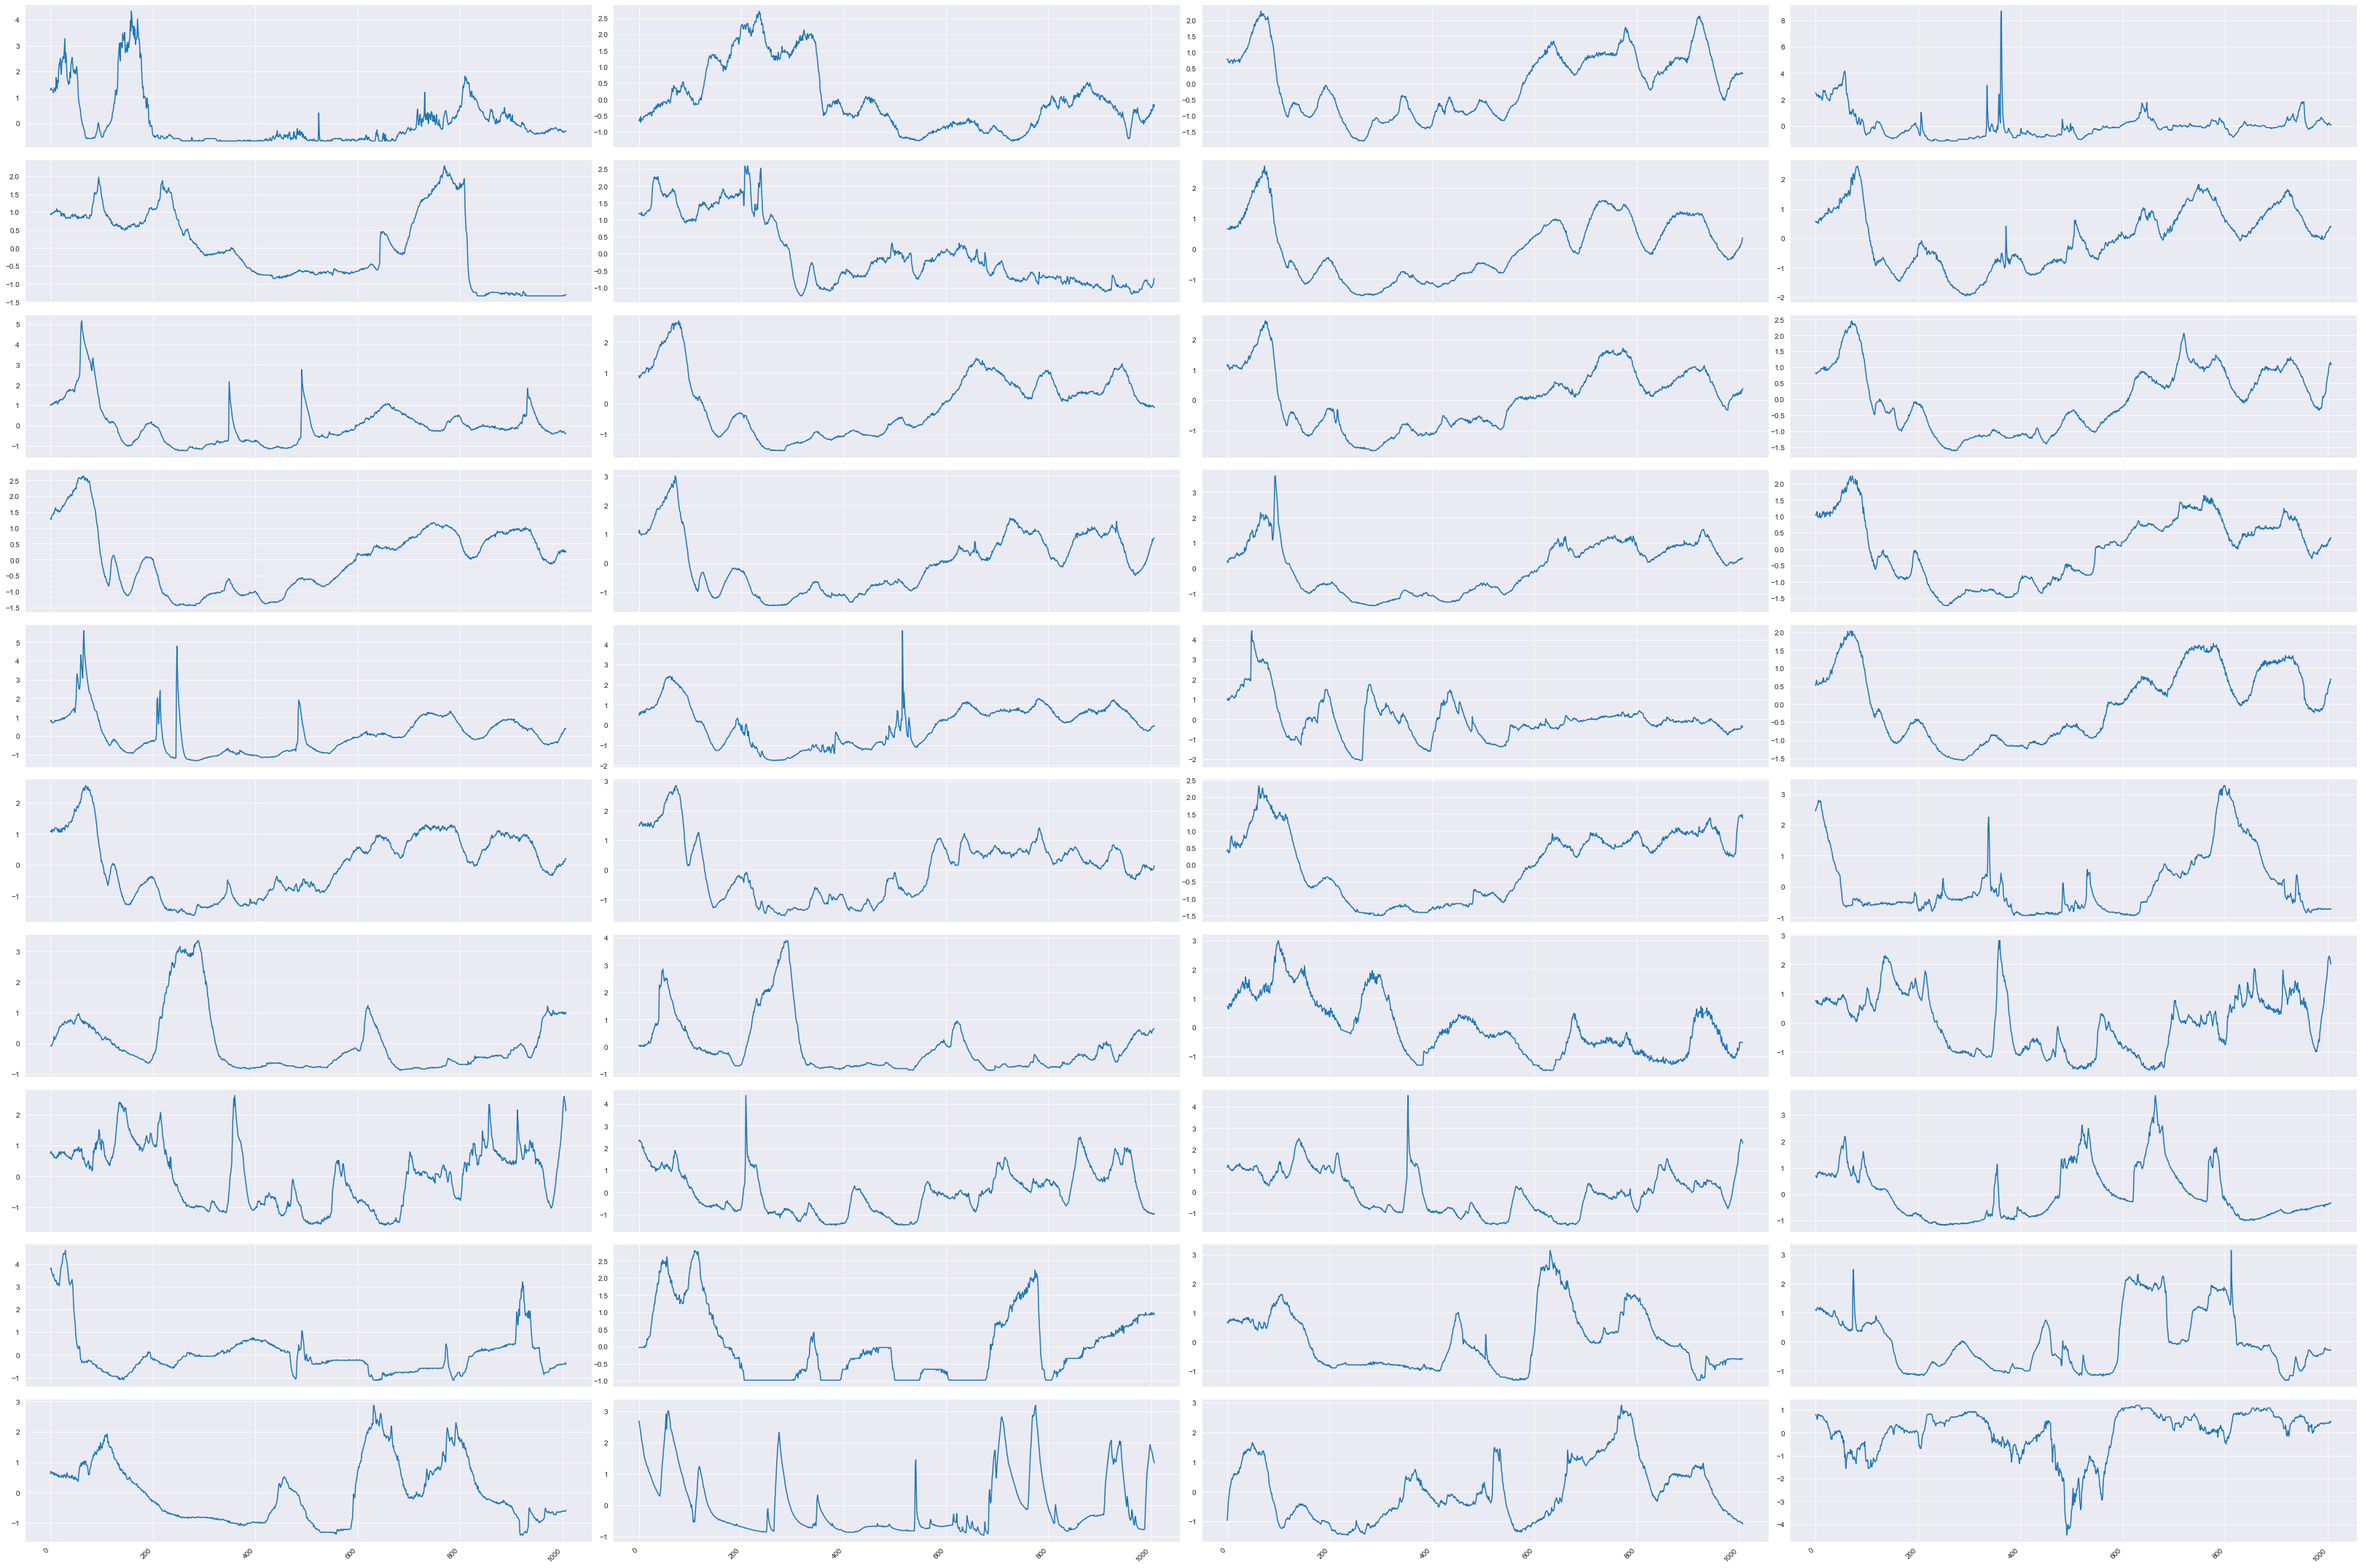

[0, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 34, 41, 44, 47, 54, 55, 56, 57, 75, 78, 81, 86, 87, 88, 105, 134, 144]
==========Cluster number: 2==========


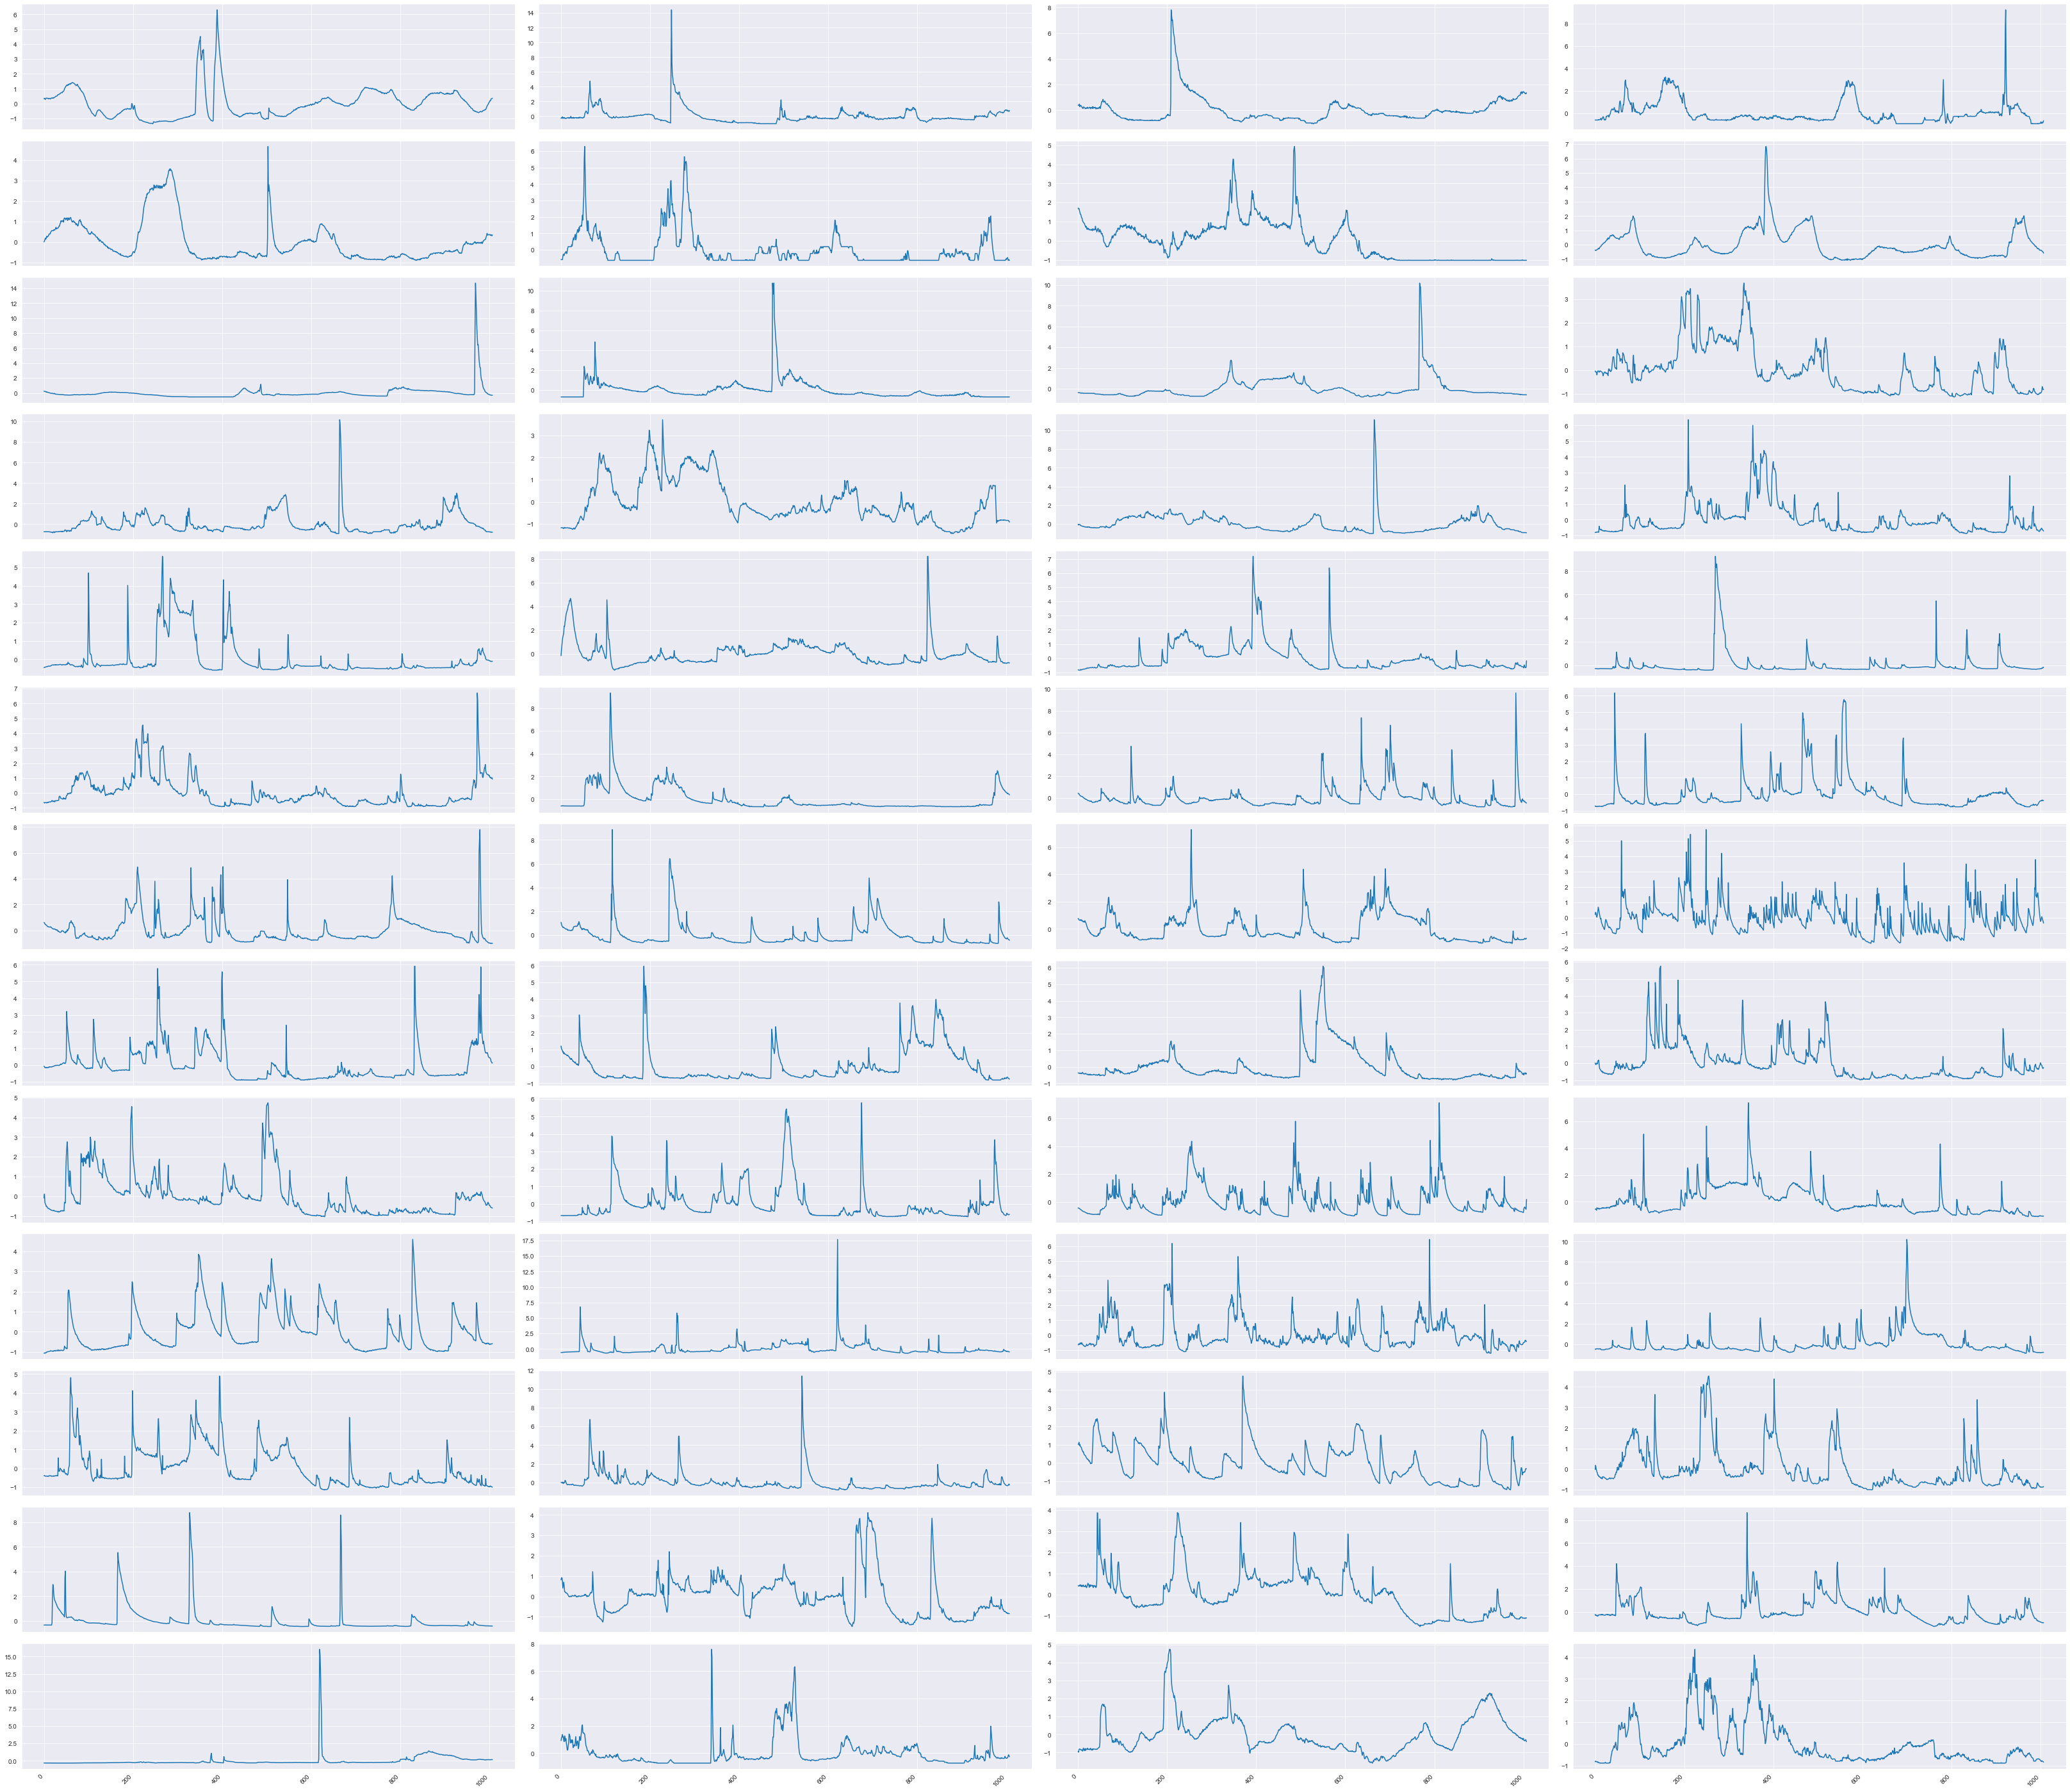

[19, 28, 31, 40, 42, 43, 51, 52, 58, 60, 79, 85, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 138, 139, 140, 148]


In [32]:
# 군집별 data sample 형태 조회
for cluster in range(len(ts_clustered)):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(ts_clustered[cluster])

In [24]:
def get_DBSCAN_parameter(data, eps_values = np.arange(3,8.75,0.25), min_samples = np.arange(3,10)):
    """
    DBSCAN parameter 탐색 code

    data: pd.DataFrame or np.array
        Time Series Data

    eps_values: np.arange
        eps of DBSCAN
        # eps values to be investigated

    min_samples: np.arange
        min_sample of DBSCAN
        # min_samples values to be investigated
    Returns:
    -------
    None
    """
    DBSCAN_params = list(product(eps_values, min_samples))

    no_of_clusters = []
    sil_score = []
    noise = []
    eps = []
    min_sample = []

    for p in DBSCAN_params:
        DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(data)
        clusters = DBS_clustering.labels_
        n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise_ = list(clusters).count(-1)

        if n_clusters_ > 1:
            eps.append(p[0])
            min_sample.append(p[1])
            noise.append(n_noise_)
            no_of_clusters.append(n_clusters_)
            sil_score.append(silhouette_score(data, clusters))


    dict = {'Eps': eps,'Min_samples': min_sample}
    tmp= pd.DataFrame(dict)
    #######################################No_of_clusters############################################################
    tmp['No_of_clusters'] = no_of_clusters
    pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(12,6))
    sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
    ax.set_title('Number of clusters')
    plt.show()

    ###########################################Sil_score########################################################
    tmp['Sil_score'] = sil_score
    pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(18,6))
    sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax, fmt = '.3f')
    ax.set_title('Sil score')
    plt.show()

    ###########################################Noise########################################################
    tmp['Noise'] = noise
    pivot_1 = pd.pivot_table(tmp, values='Noise', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(18,6))
    sns.heatmap(pivot_1, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", ax=ax, fmt = '.1f')
    ax.set_title('Noise')
    plt.show()



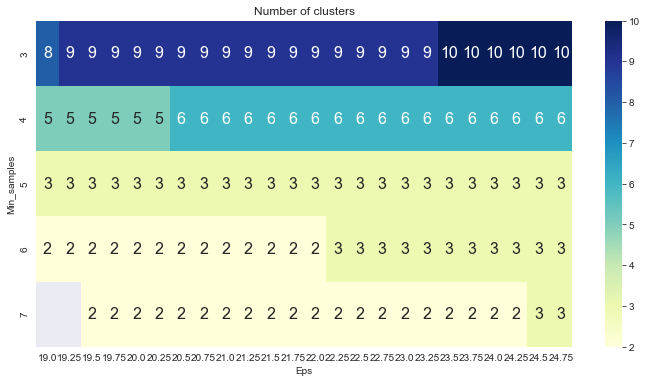

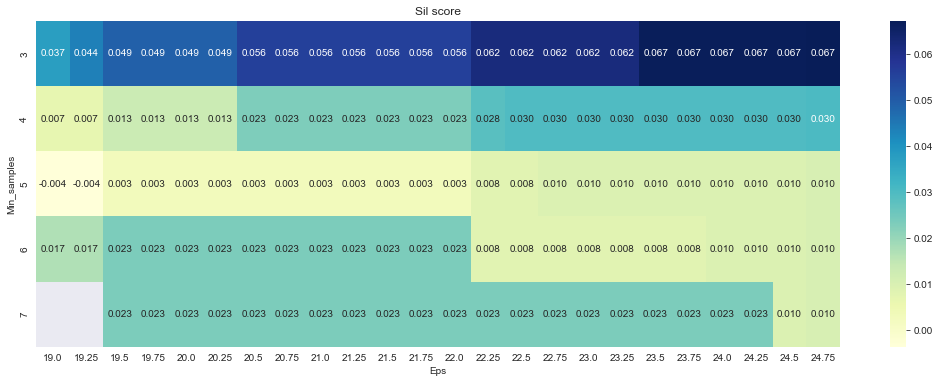

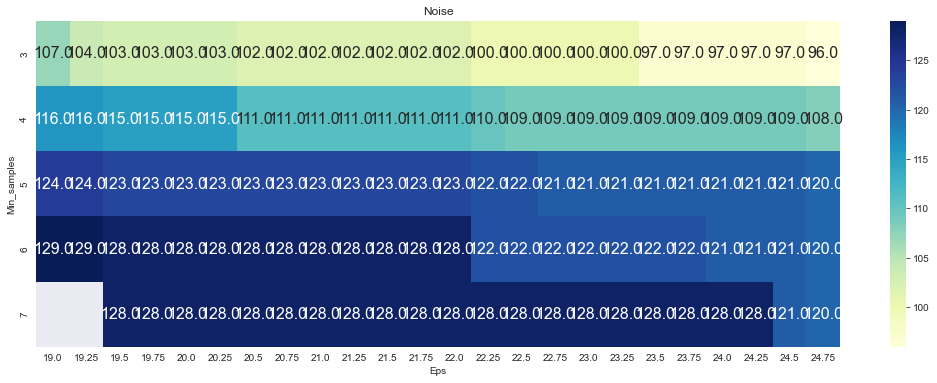

In [25]:
# DBSCAN을 eps_values 범위와 min_samples로 각각 진행하여 클러스터 수와 Sil_score, Noise 결과 시각화
get_DBSCAN_parameter(scaled_ts_df, eps_values = np.arange(19,25,0.25), min_samples = np.arange(3,15))

In [26]:
def get_DBSCAN_results(data, min_samples=10, eps = 0.726):
    """
    파라미터를 지정하여 DBSCAN 결과 생성

    data: pd.DataFrame or np.array
        Time Series Data
    min_samples: int
        # 최소 요소 갯수
    eps: int
        # R와 역할, 반지름 지정

    Returns:
    -------
    None
    """
    # Main metrics

    DBSCAN_model = DBSCAN(eps=eps, min_samples = min_samples)
    DBSCAN_model.fit(data)
    clusters_ss= DBSCAN_model.fit_predict(data)
    clusters = DBSCAN_model.labels_
    n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise_ = list(clusters).count(-1)


    core_samples = np.zeros_like(clusters, dtype=bool)
    core_samples[DBSCAN_model.core_sample_indices_] = True
    #print("Number of core samples:", core_samples)


    print("Number of clusters: %d" % n_clusters_)
    print("Number of noise points: %d" % n_noise_)
    for i in range(n_clusters_):
        print('Cluster', i, ':', len(clusters[clusters==i]))

    print("Silhouette Coefficient: %0.3f" % silhouette_score(data, clusters))



In [27]:
# min_samples=3, eps = 19.75의 DBSCAN 결과
get_DBSCAN_results(data = scaled_ts_df , min_samples=3, eps = 19.75)

Number of clusters: 9
Number of noise points: 103
Cluster 0 : 17
Cluster 1 : 4
Cluster 2 : 7
Cluster 3 : 3
Cluster 4 : 4
Cluster 5 : 3
Cluster 6 : 3
Cluster 7 : 3
Cluster 8 : 5
Silhouette Coefficient: 0.049


In [34]:
# in_id의 군집결과 조회
cluster_model = DBSCAN(min_samples=3, eps = 19.75)
cluster_labels = cluster_model.fit_predict(scaled_ts_df)
fancy_names_for_labels = [f"Cluster {label}" for label in cluster_labels]
result = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")
ts_clustered = [scaled_ts_df.iloc[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]
result

Cluster
Series                  
ICL1L2000011  Cluster -1
ICW0W2000805  Cluster -1
ICW0W2000802  Cluster -1
ICW0W2000799  Cluster -1
ICW0W2000798  Cluster -1
...                  ...
IS70W2000856   Cluster 8
IS70W2000851   Cluster 8
IS70W2000852   Cluster 8
IS70W2000853   Cluster 8
IS70W2000855   Cluster 8

[152 rows x 1 columns]

In [35]:
# 군집별 data sample 수 조회
merge_outer = pd.merge(result,data_cd, how='outer', left_index=True, right_index=True)
result_cnt = merge_outer.groupby('Cluster').count().reset_index()
result_cnt

Cluster  in_serial
0  Cluster -1        103
1   Cluster 0         17
2   Cluster 1          4
3   Cluster 2          7
4   Cluster 3          3
5   Cluster 4          4
6   Cluster 5          3
7   Cluster 6          3
8   Cluster 7          3
9   Cluster 8          5

==========Cluster number: 0==========


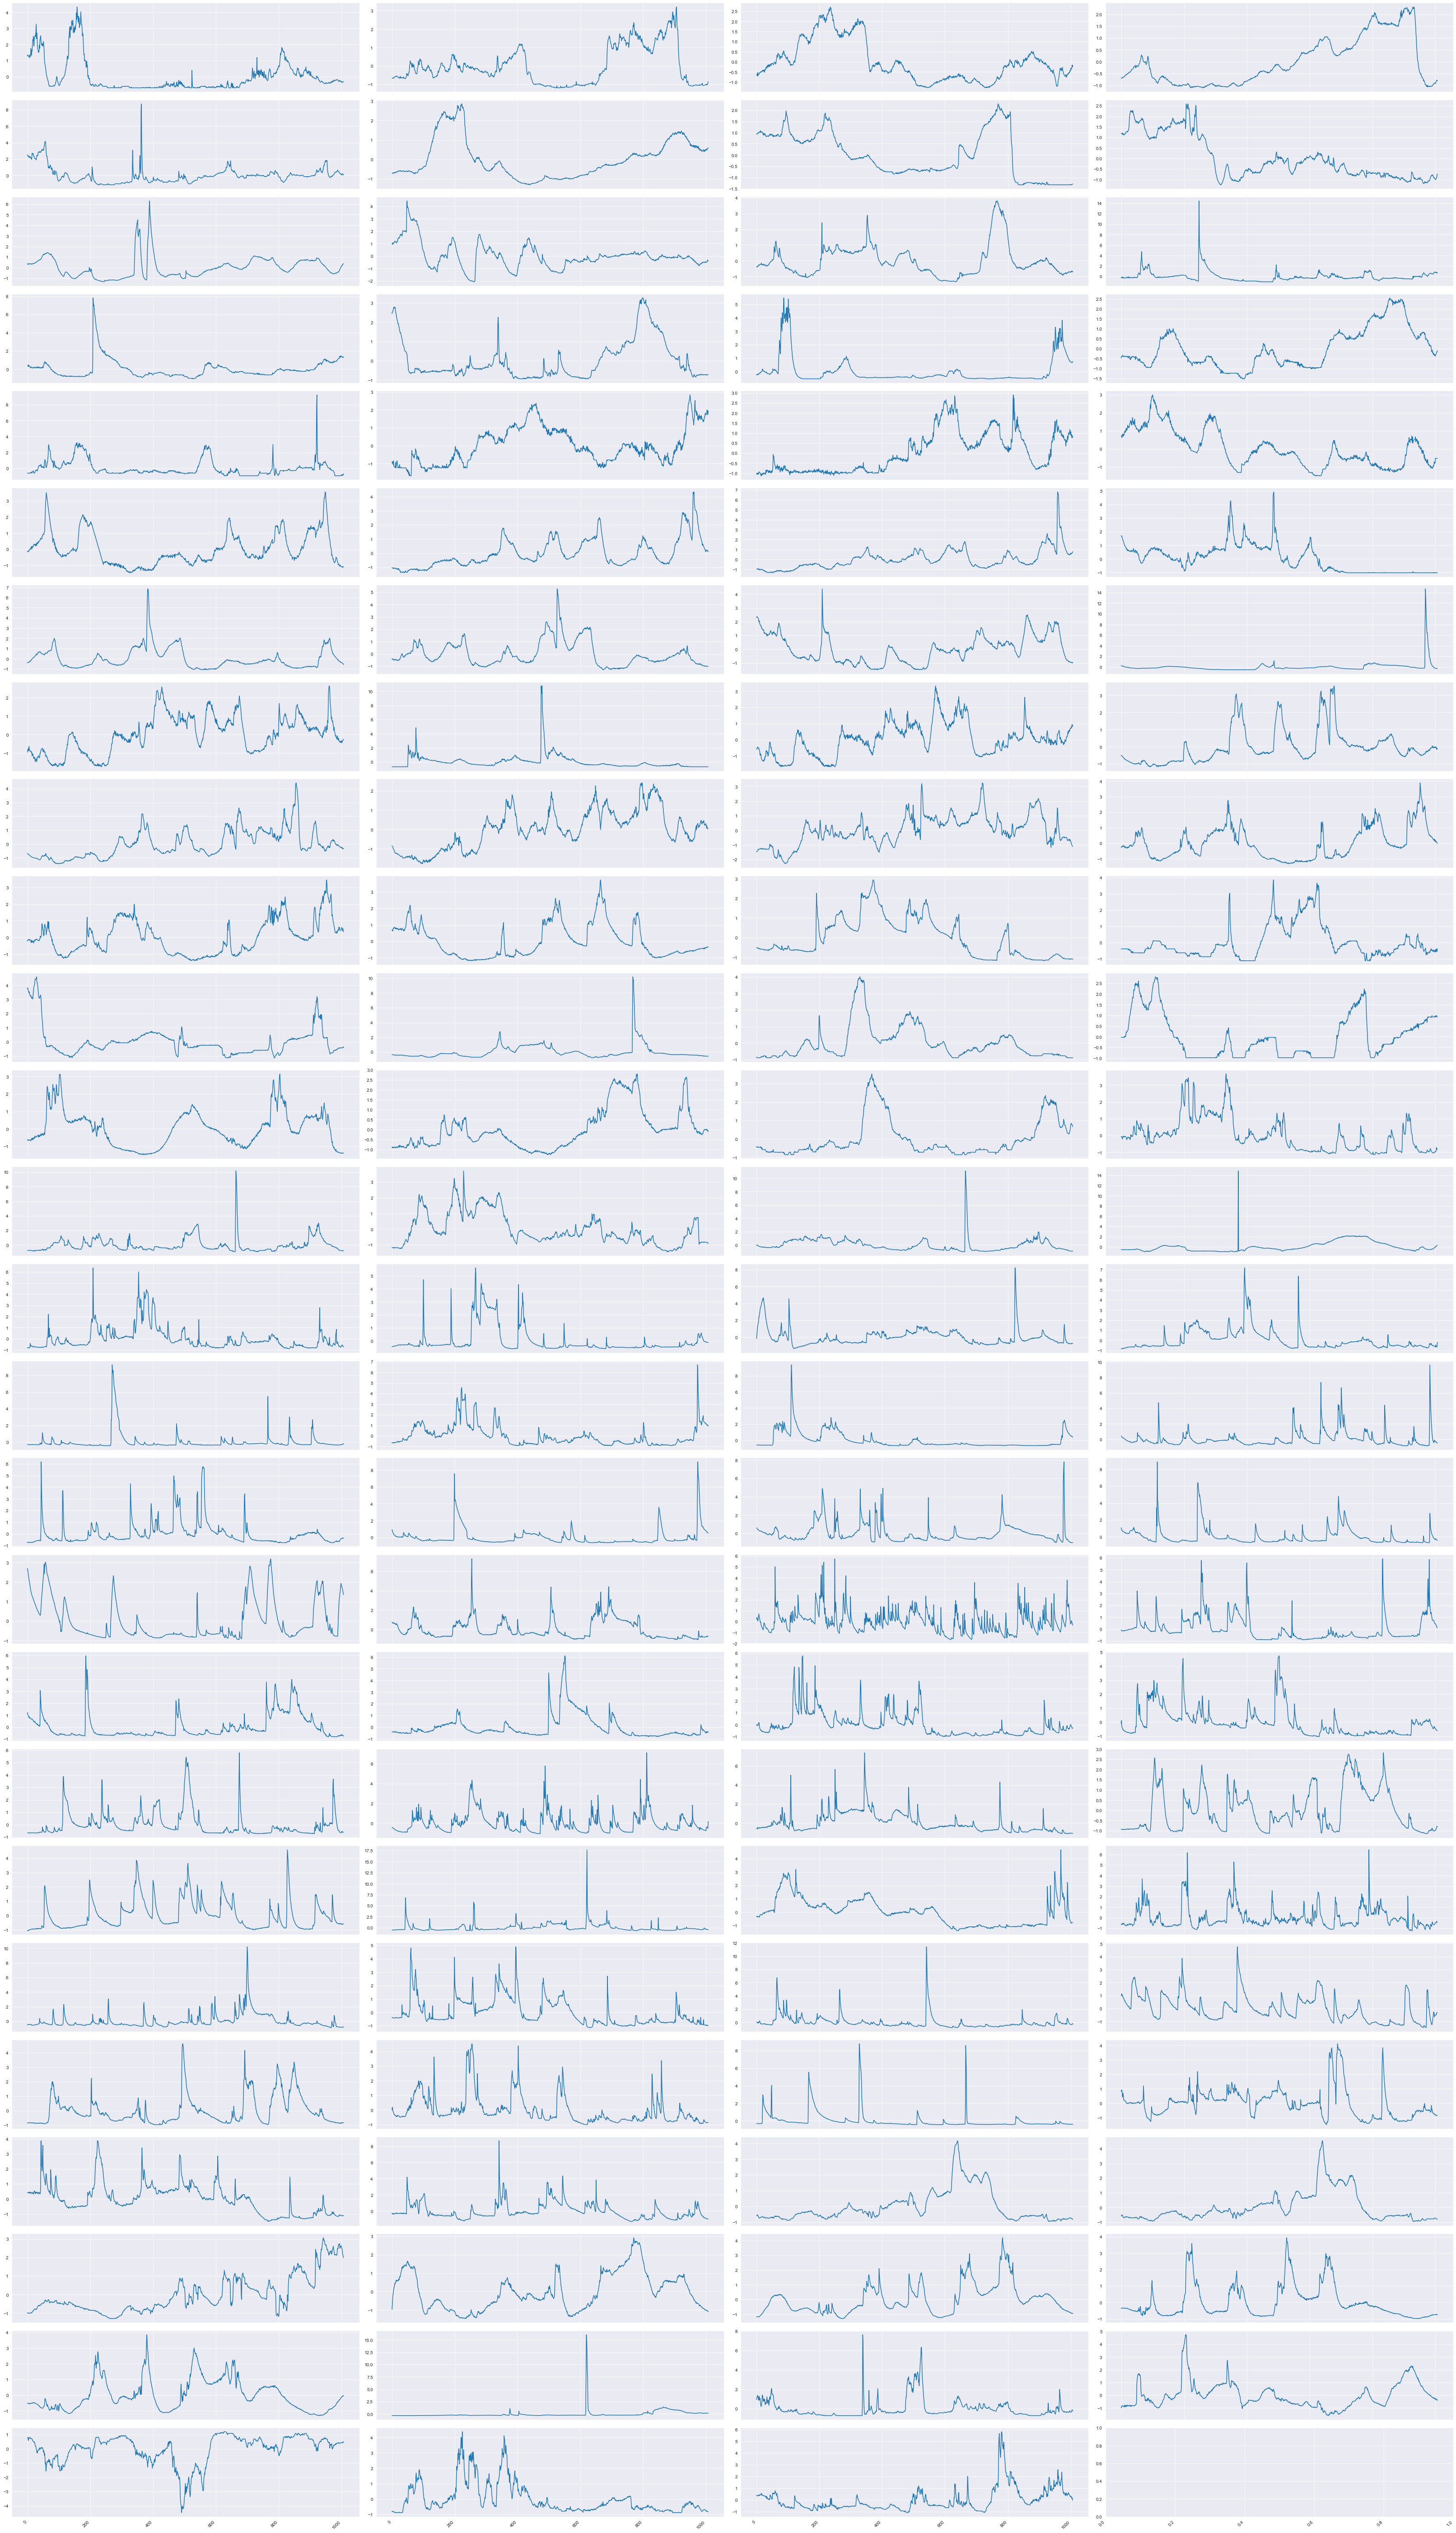

[0, 1, 2, 3, 5, 6, 7, 8, 19, 22, 23, 28, 31, 34, 36, 39, 40, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 63, 64, 66, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 144, 148, 151]
==========Cluster number: 1==========


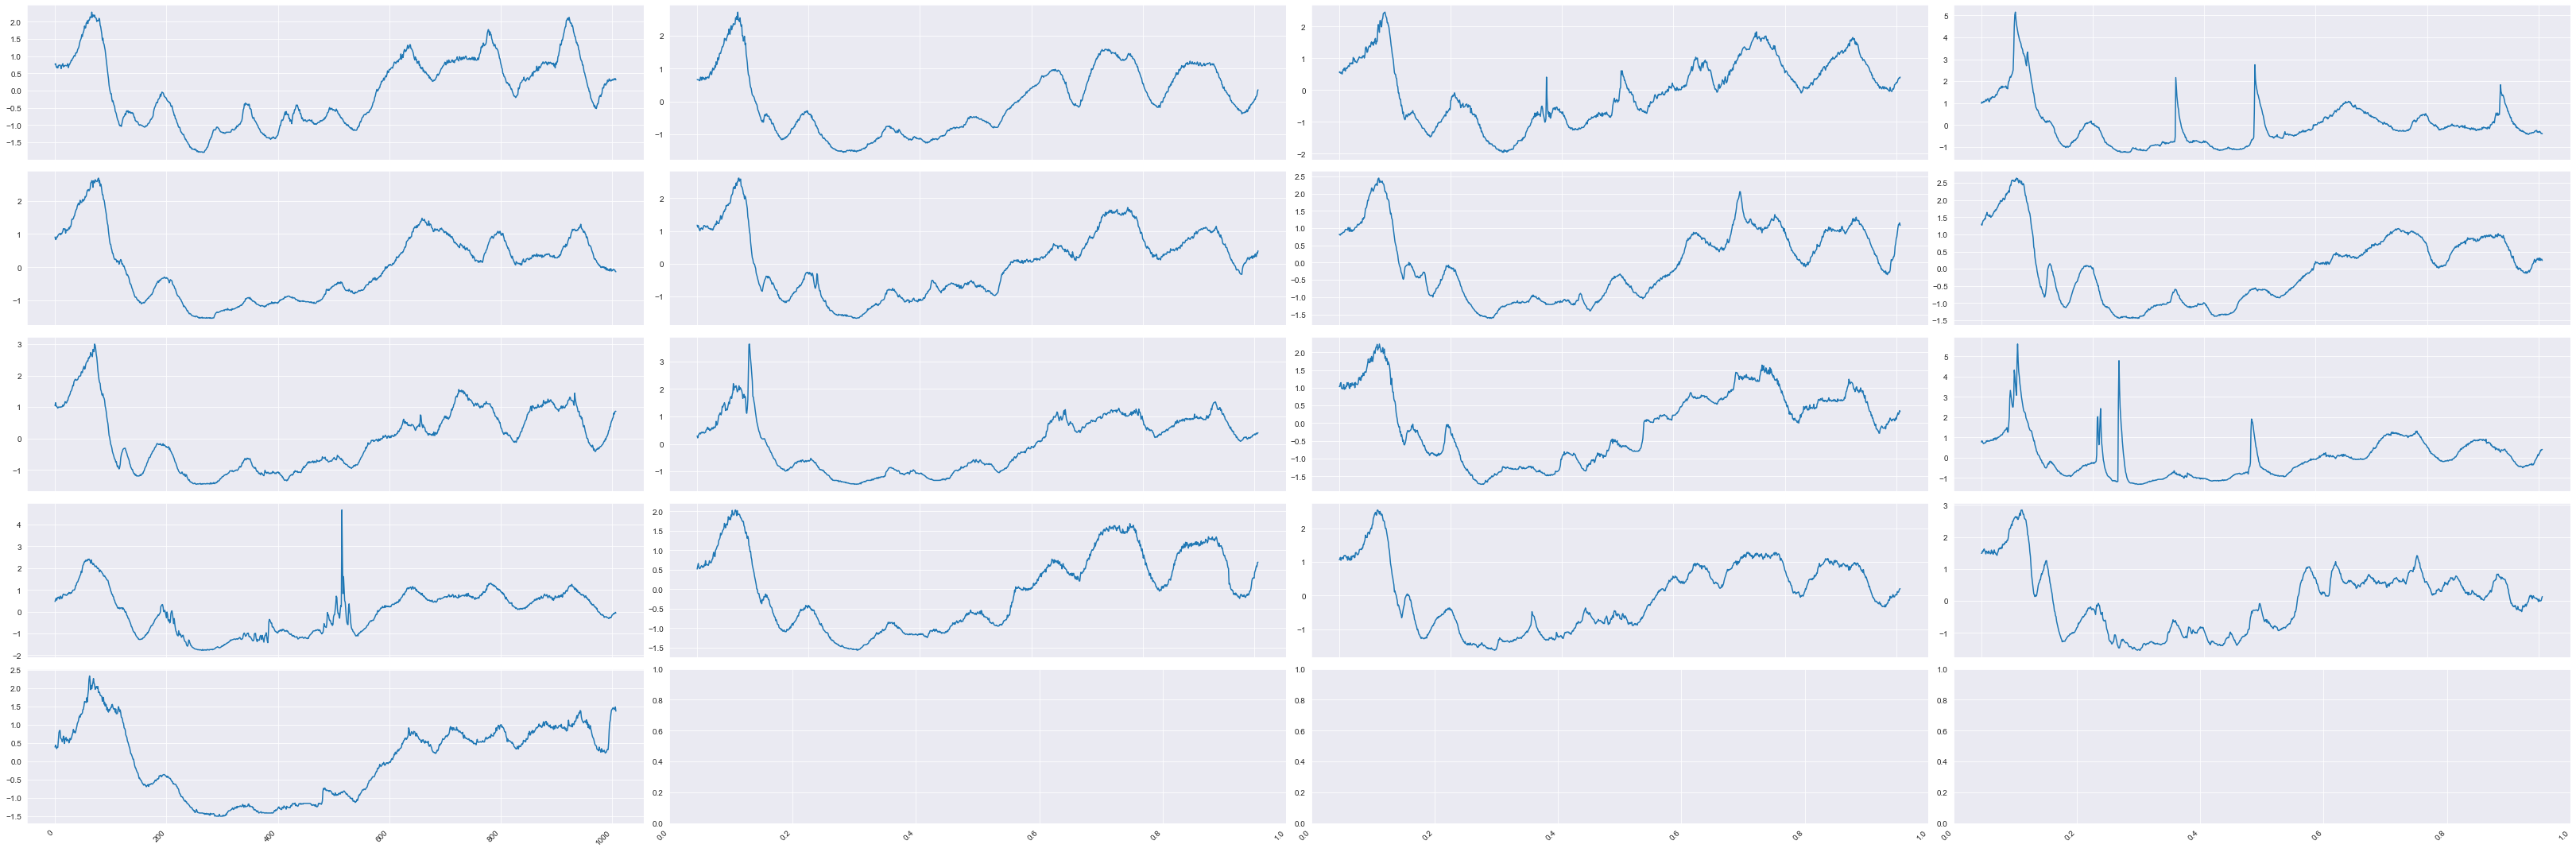

[4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 26, 27]
==========Cluster number: 2==========


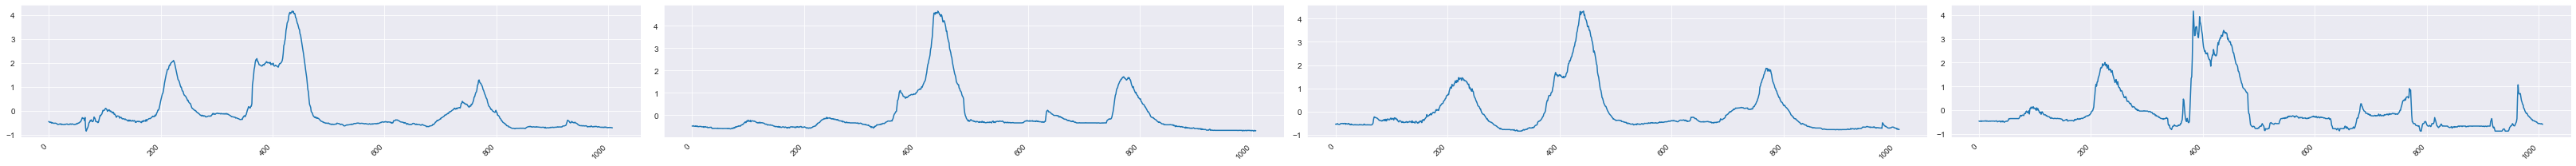

[29, 30, 32, 35]
==========Cluster number: 3==========


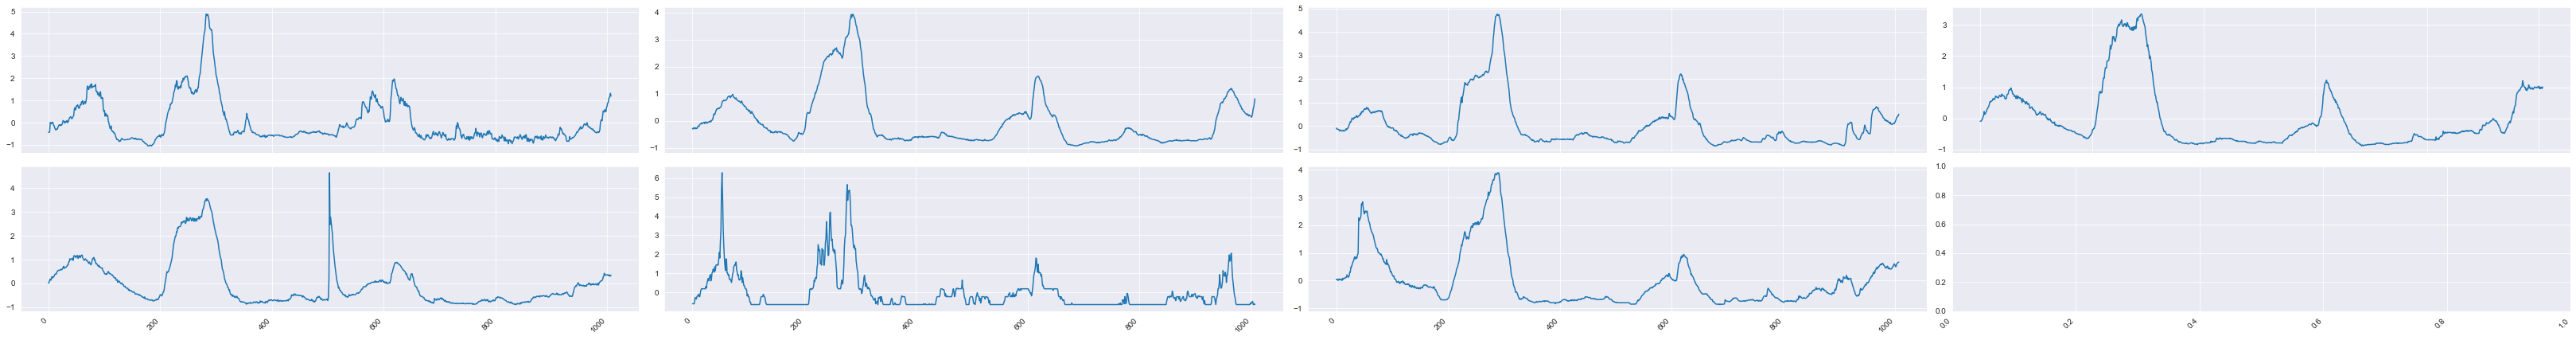

[33, 37, 38, 41, 42, 43, 44]
==========Cluster number: 4==========


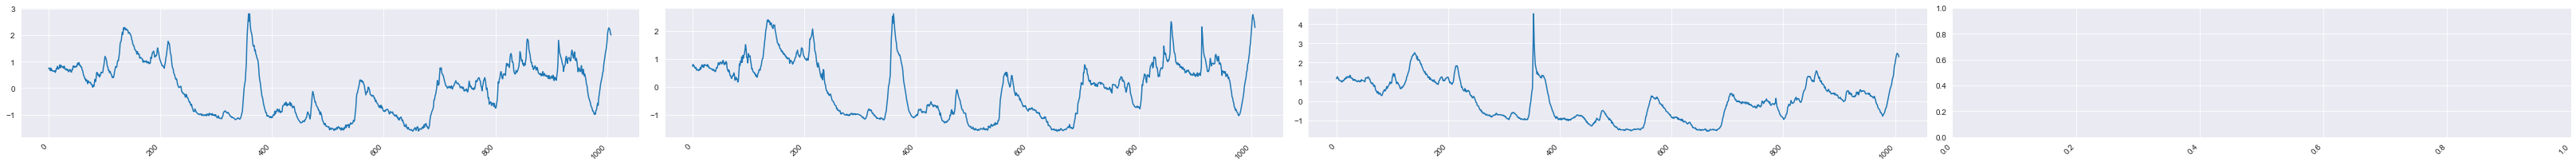

[54, 55, 57]
==========Cluster number: 5==========


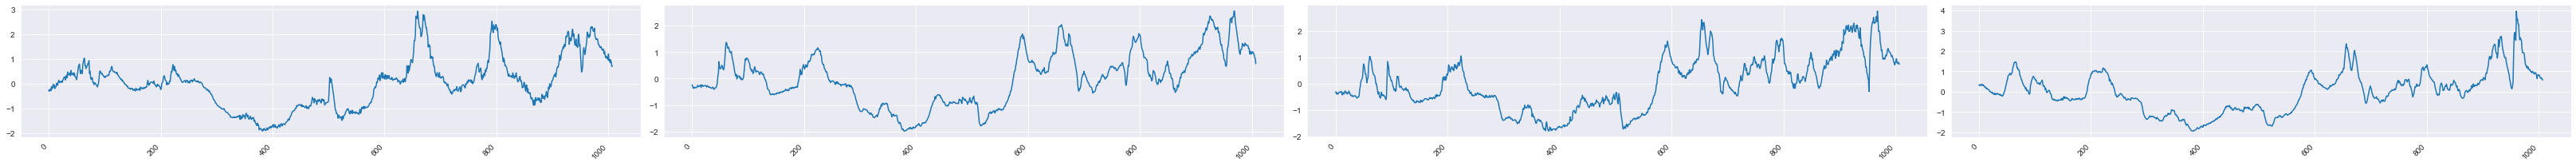

[65, 70, 71, 72]
==========Cluster number: 6==========


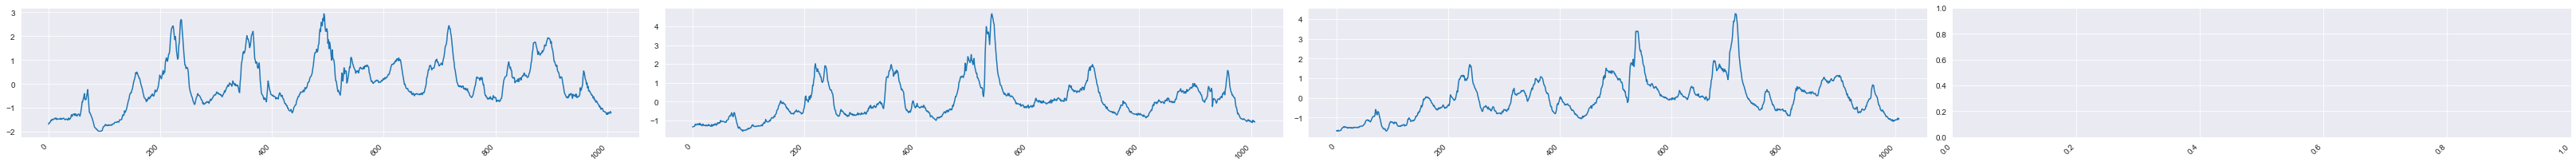

[67, 68, 69]
==========Cluster number: 7==========


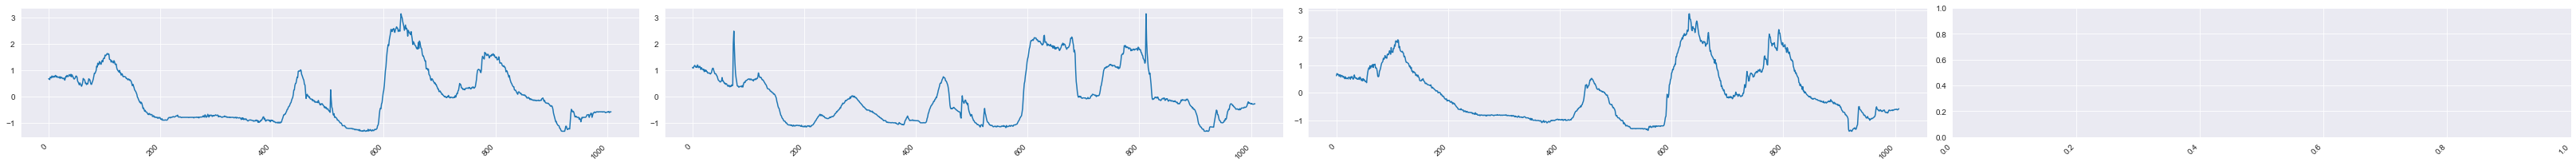

[86, 87, 88]
==========Cluster number: 8==========


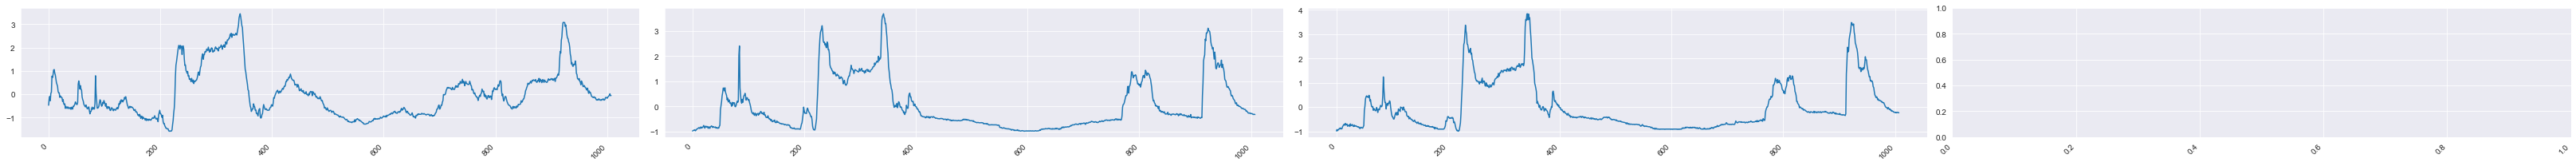

[141, 142, 143]
==========Cluster number: 9==========


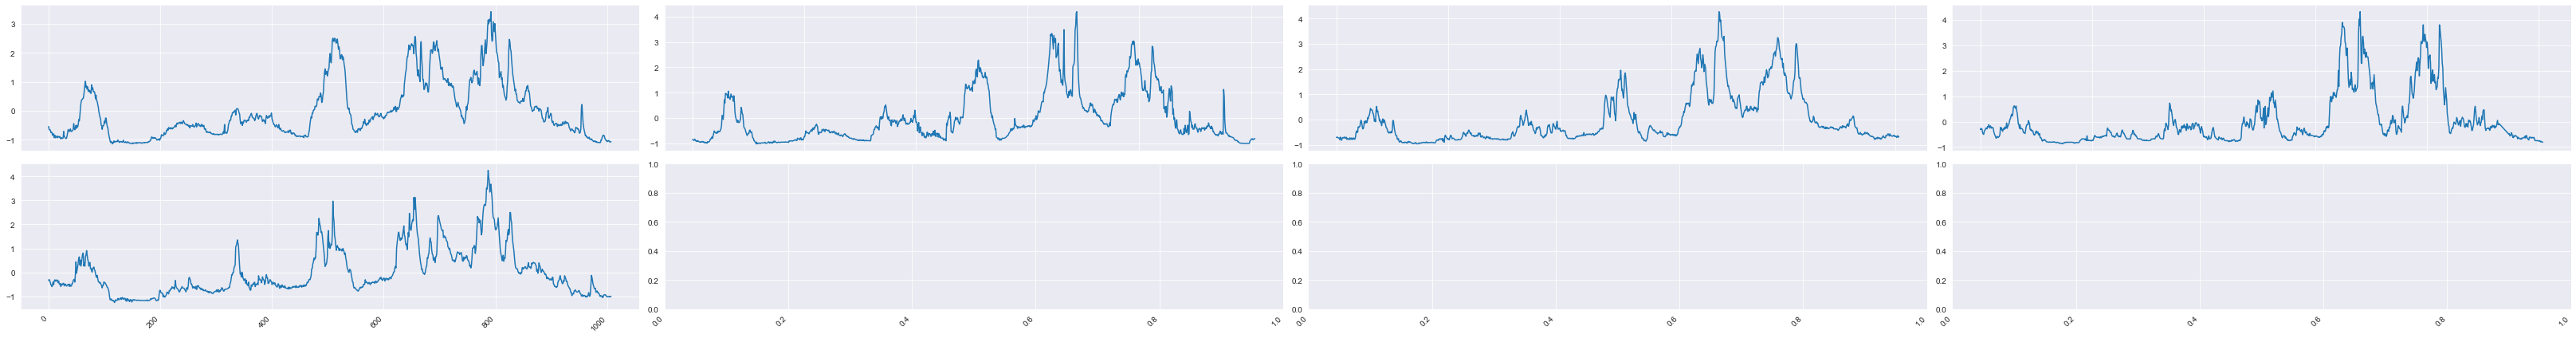

[145, 146, 147, 149, 150]


In [36]:
# cluster_model = DBSCAN(min_samples=3, eps = 19.75)

for cluster in range(len(ts_clustered)):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(ts_clustered[cluster])

In [48]:
pm10_clustering_result= df_pivot_int_test.T.copy()
pm10_clustering_result = pm10_clustering_result.reset_index()
pm10_clustering_result

time_index         in_id     0     1     2     3     4     5     6          7  \
0           ICL1L2000011  21.5  22.3  21.8  21.5  21.5  21.1  20.3  21.777778   
1           ICL1L2000017  11.4  11.3  11.3  11.5  11.1  11.8  12.0  12.200000   
2           ICL1L2000064  15.3  15.2  16.1  14.5  16.9  15.3  15.5  15.500000   
3           ICL1L2000065  16.2  16.2  16.6  16.7  16.9  16.6  16.8  17.100000   
4           ICL1L2000234  43.3  43.5  42.5  41.9  42.2  41.8  42.8  42.800000   
..                   ...   ...   ...   ...   ...   ...   ...   ...        ...   
147         IS70W2000853   5.9   6.2   6.0   5.6   5.6   5.4   4.3   6.200000   
148         IS70W2000854   0.7   1.0   0.7   0.8   0.7   0.7   0.3   0.500000   
149         IS70W2000855   8.7   9.5   8.9   9.0   6.9   6.0   5.8   7.600000   
150         IS70W2000856  14.1  14.6  13.8  13.1  11.7  11.5  10.7  11.800000   
151         IS70W2000858  12.6  12.2  12.3  12.2  12.4  12.3  12.7  12.400000   

time_index     8  ...   998   999  1000  1001  1002  1003  1004  1005  1006  \
0           22.4  ...   4.5   4.2   4.3   3.6   4.0   3.8   4.0   3.9   4.1   
1           12.4  ...   3.4   3.8   3.8   4.4   3.9   3.3   3.6   4.1   5.5   
2           15.9  ...  18.1  18.4  17.9  19.8  19.1  19.3  19.8  21.8  20.7   
3           17.3  ...  12.6  12.4  12.1  12.5  13.3  13.8  14.0  14.7  14.2   
4           42.9  ...  36.5  36.9  36.8  37.2  36.9  37.1  37.5  37.1  37.5   
..           ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
147          5.1  ...   7.0   7.4   6.6   6.6   6.8   5.9   6.4   7.2   6.1   
148          0.3  ...   2.0   1.7   1.3   1.1   0.8   1.2   1.0   0.9   0.7   
149          8.3  ...   2.0   2.0   1.6   1.9   1.8   1.2   1.6   1.2   1.2   
150         13.2  ...   5.7   5.4   5.0   5.1   5.2   5.1   5.3   5.0   5.2   
151         12.5  ...  12.2  11.8  11.7  12.0  11.9  11.1  10.6  11.1   9.8   

time_index  1007  
0            4.3  
1            7.2  
2           21.7  
3           14.8  
4           37.0  
..           ...  
147          6.5  
148          0.5  
149          1.0  
150          5.3  
151          9.6  

[152 rows x 1009 columns]

## clustering 결과 라벨링

In [49]:
pm10_clustering_result= df_pivot_int_test.T.copy()
pm10_clustering_result = pm10_clustering_result.reset_index()

In [ ]:
# 클러스터 결과와 input data set을 merge 하여 예측을 위한 data set 생성
test = pd.merge(pm10_clustering_result,result, how='left', left_on='in_id', right_on='Series')

In [54]:
test.head()

in_id     0     1     2     3     4     5     6          7     8  \
0  ICL1L2000011  21.5  22.3  21.8  21.5  21.5  21.1  20.3  21.777778  22.4   
1  ICL1L2000017  11.4  11.3  11.3  11.5  11.1  11.8  12.0  12.200000  12.4   
2  ICL1L2000064  15.3  15.2  16.1  14.5  16.9  15.3  15.5  15.500000  15.9   
3  ICL1L2000065  16.2  16.2  16.6  16.7  16.9  16.6  16.8  17.100000  17.3   
4  ICL1L2000234  43.3  43.5  42.5  41.9  42.2  41.8  42.8  42.800000  42.9   

   ...  1000  1001  1002  1003  1004  1005  1006  1007        Series  \
0  ...   4.3   3.6   4.0   3.8   4.0   3.9   4.1   4.3  ICL1L2000011   
1  ...   3.8   4.4   3.9   3.3   3.6   4.1   5.5   7.2  ICL1L2000017   
2  ...  17.9  19.8  19.1  19.3  19.8  21.8  20.7  21.7  ICL1L2000064   
3  ...  12.1  12.5  13.3  13.8  14.0  14.7  14.2  14.8  ICL1L2000065   
4  ...  36.8  37.2  36.9  37.1  37.5  37.1  37.5  37.0  ICL1L2000234   

      Cluster  
0  Cluster -1  
1  Cluster -1  
2  Cluster -1  
3  Cluster -1  
4   Cluster 0  

[5 rows x 1011 columns]

In [51]:
PM10_clustering_result = test.drop(["Series"], axis=1)

In [53]:
PM10_clustering_result.head()

in_id     0     1     2     3     4     5     6          7     8  \
0  ICL1L2000011  21.5  22.3  21.8  21.5  21.5  21.1  20.3  21.777778  22.4   
1  ICL1L2000017  11.4  11.3  11.3  11.5  11.1  11.8  12.0  12.200000  12.4   
2  ICL1L2000064  15.3  15.2  16.1  14.5  16.9  15.3  15.5  15.500000  15.9   
3  ICL1L2000065  16.2  16.2  16.6  16.7  16.9  16.6  16.8  17.100000  17.3   
4  ICL1L2000234  43.3  43.5  42.5  41.9  42.2  41.8  42.8  42.800000  42.9   

   ...   999  1000  1001  1002  1003  1004  1005  1006  1007     Cluster  
0  ...   4.2   4.3   3.6   4.0   3.8   4.0   3.9   4.1   4.3  Cluster -1  
1  ...   3.8   3.8   4.4   3.9   3.3   3.6   4.1   5.5   7.2  Cluster -1  
2  ...  18.4  17.9  19.8  19.1  19.3  19.8  21.8  20.7  21.7  Cluster -1  
3  ...  12.4  12.1  12.5  13.3  13.8  14.0  14.7  14.2  14.8  Cluster -1  
4  ...  36.9  36.8  37.2  36.9  37.1  37.5  37.1  37.5  37.0   Cluster 0  

[5 rows x 1010 columns]

In [74]:
# 클러스터링 결과 csv 저장
address = './../data_processing/Dataset/'
test.to_csv(os.path.join(address,'PM10_clustering_result_1010.csv'), encoding="cp949", index=False)